# Steps


1. Read the data from the csv file
2. Read the sequences from the pkl file
3. Coompute the covariances
4. Order their rows/columns

In [7]:
%matplotlib inline
import time
import os
import warnings
import seaborn as sns
import numpy as np
import pandas as pd
import numpy.ma as ma
import pickle
from kde_ebm.mixture_model import fit_all_gmm_models
from kde_ebm import mixture_model
from sSuStaIn.sEBMSustain import sEBMSustain, sEBMSustainData
from matplotlib import pyplot as plt

In [2]:
cn_ad_path = "/home/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_D12_ebm_final_n327.csv"
df_cnad = pd.read_csv(cn_ad_path)

In [3]:
def process_L(L, min_val=0):
    mx = ma.masked_less_equal(L,min_val)
    min_masked = mx.min(axis=0)
    L_new = mx.filled(fill_value=min_masked)
    return L_new

def filter_df(df, visit):
    return df[df["VISCODE"].isin([visit])]

In [8]:
# Get the mixture model for the CN/AD subjects
k=119
X = df_cnad.iloc[:,:k].values
bm_names = df_cnad.columns[:k].tolist()
y = df_cnad["DX"].map({"Dementia":1, "CN":0})
mm_fit = mixture_model.fit_all_gmm_models
mixture_models = mm_fit(X, y)
L_yes = np.zeros(X.shape)
L_no = np.zeros(X.shape)
for i in range(k):
    L_no[:, i], L_yes[:, i] = mixture_models[i].pdf(None, X[:, i])

L_no = process_L(L_no)
L_yes = process_L(L_yes)

/home/rtandon32/.conda/envs/sustain/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


In [14]:
path = "/nethome/rtandon32/ebm/ebm_experiments/experiment_scripts/real_data/dfMri_all_aligned.csv"
df = pd.read_csv(path)
k=119
# select_cols = [_ for _ in range(k) if _ not in exclude_idx]
# X = df.iloc[:,:k].values
# bm_names = df.columns.tolist()[:k]
# y = df["DX"].map({"Dementia":1, "CN":0, "MCI":2})

In [20]:
# Re-order the columns so the are in the same order as the mixture_model object
demo_cols = df.columns.difference(bm_names)
df_demo = df[demo_cols]
df_bm =   df[bm_names]
df =pd.concat([df_bm, df_demo], axis=1)

In [21]:
# Read the pickled file
pickle_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/sim_tadpole9_mixture_GMM/pickle_files/sim_tadpole9_subtype3.pickle"
with open(pickle_path, "rb") as input_file:
    pkl = pickle.load(input_file)

In [24]:
prob_mat_all = mixture_model.get_prob_mat(df.iloc[:,:k].values, mixture_models)
L_no_all = prob_mat_all[:,:,0]
L_yes_all = prob_mat_all[:,:,1]
L_no_all = process_L(L_no_all)
L_yes_all = process_L(L_yes_all)

In [25]:
# Create the SuStaIn object for the sEBM model
stage_sizes = [24,24,24,24,23]
N_startpoints           = 25
N_S_max                 = 3
rep = 20
N_iterations_MCMC_init = int(2e4)
N_iterations_MCMC       = int(5e5)  #Generally recommend either 1e5 or 1e6 (the latter may be slow though) in practice
n_stages = 5
min_clust_size = 8
p_absorb = 0.3
N_em = 100
SuStaInLabels = df.columns[:k].tolist()
dataset_name            = 'sim_tadpole9_covar'
output_dir              = '/home/rtandon32/ebm/s-SuStain-outputs'
sustainType             = 'mixture_GMM'
output_folder           = os.path.join(output_dir, dataset_name + '_' + sustainType)
use_parallel_startpoints = True
sustain = sEBMSustain(L_yes_all, L_no_all, n_stages, stage_sizes, min_clust_size, p_absorb, 
                      rep, SuStaInLabels, N_startpoints, N_S_max, N_iterations_MCMC_init, 
                      N_iterations_MCMC, N_em, output_folder, dataset_name, use_parallel_startpoints)

In [42]:
pkl["samples_f"][:,0], pkl["samples_f"][:,-1]

(array([0.07606729, 0.5104032 , 0.29264003, 0.12088949]),
 array([0.08245661, 0.51016949, 0.28827324, 0.11910066]))

In [58]:
# Subtype and Stage all subjects
last_N = 1
N_samples = 1
sustainData_all = sEBMSustainData(L_yes_all, L_no_all, n_stages)
samples_sequence = pkl["samples_sequence"][:,:,0]
samples_sequence = np.expand_dims(samples_sequence, axis=2)
samples_f = pkl["samples_f"][:,0].reshape(-1,1)
shape_seq = pkl["shape_seq"]
temp_mean_f = np.mean(samples_f, axis=1)
ix = np.argsort(temp_mean_f)[::-1]

ml_subtype_all, \
prob_ml_subtype_all, \
ml_stage_all, \
prob_ml_stage_all, \
prob_subtype_all, \
prob_stage_all, \
prob_subtype_stage_all,_ = sustain.subtype_and_stage_individuals(sustainData_all, shape_seq, samples_sequence, samples_f, N_samples)


In [59]:
# Add the subtypes and stages to the df columns
df["subtype"] = ml_subtype_all
df["stage"] = ml_stage_all

In [60]:
seq = sustain._flatten_sequence(pkl["ml_sequence_EM"])
sort_idx = np.argsort(pkl["ml_f_EM"])[::-1]
seq = seq[sort_idx]
shape_seq = pkl["shape_seq"][sort_idx]

In [118]:
figsave_path = "/nethome/rtandon32/ebm/s-SuStain-outputs/data_dump/figures/covar_analysis/CN/"

Data shape (30, 119)


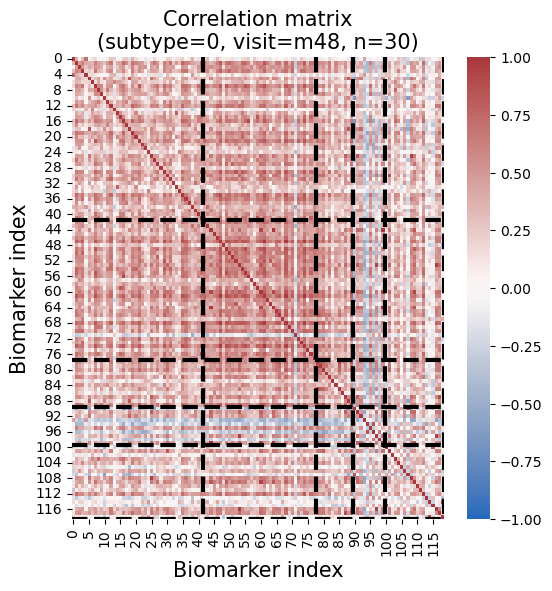

In [127]:
fig, ax = plt.subplots(figsize=(6,6))
subtype=0
viscode="m48"
f_df = df[df["subtype"]==subtype]
f_df = f_df[f_df["VISCODE"]==viscode]
f_df = f_df[f_df["DX"]=="CN"]
X = f_df.iloc[:,:k].values[:,seq[subtype]]
cov = np.corrcoef(X.T)
cmap = sns.color_palette("vlag", as_cmap=True)
print("Data shape", X.shape)
sns.heatmap(cov, vmin=-1, vmax=1, center=0, cmap=cmap, ax=ax, square=False)
ax.hlines(np.cumsum(shape_seq[subtype]), 0, 119, color='k', linestyle="--", linewidth=3)
ax.vlines(np.cumsum(shape_seq[subtype]), 0, 119, color='k', linestyle="--", linewidth=3)
ax.set_title("Correlation matrix\n(subtype={}, visit={}, n={})".format(subtype,viscode,X.shape[0]), fontsize=15)
ax.set_xlabel("Biomarker index", fontsize=15)
ax.set_ylabel("Biomarker index", fontsize=15)
fig.savefig(os.path.join(figsave_path, "subtype_{}_visit_{}.png".format(subtype,viscode)))

In [108]:
df["DX"].unique()

array(['CN', 'Dementia', 'MCI', nan], dtype=object)

In [ ]:

dx_list = [0,1,2]
subtype = pkl["ml_subtype"]
cov_data = X_cnad[(subtype == idx).reshape(-1) & (y_cnad.isin(dx_list))][:,seq[idx]]
cov = np.corrcoef(cov_data.T)
cmap = sns.color_palette("vlag", as_cmap=True)
print("Data shape", cov_data.shape)
sns.heatmap(cov, vmin=-1, vmax=1, center=0, cmap=cmap, ax=ax, square=False)
ax.hlines(np.cumsum(shape_seq[idx]), 0, 119, color='k', linestyle="--", linewidth=3)
ax.vlines(np.cumsum(shape_seq[idx]), 0, 119, color='k', linestyle="--", linewidth=3)


In [ ]:
y_cnad.isin([0,1])

In [ ]:
X_cnad[(subtype == idx).reshape(-1)][:,seq[idx]].shape

In [ ]:
seq[idx]

In [ ]:
subtype = pkl["ml_subtype"]

In [ ]:
subtype.shape